In [1]:
import numpy as np
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets
from matplotlib import animation
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import h5py

class Activation(object):
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        # a = np.tanh(x)   
        return 1.0 - a**2
    def __logistic(self, x):
        return (1.0 / (1.0 + np.exp(-x)))

    def __logistic_deriv(self, a):
        # a = logistic(x) 
        return  (a * (1 - a ))
    
    def __softmax(self, x):
        #return np.exp(x)/(np.sum(np.exp(x),axis=1)[:,None])
        return (np.exp(x)/(np.sum(np.exp(x))))
    
    def __softmax_deriv(self, a):
        #a = softmax(x)
        return a * (1 - a)
    
    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__logistic_deriv
            
class HiddenLayer(object):    
    def __init__(self,n_in, n_out,
                 activation_last_layer='tanh',activation='tanh', W=None, b=None):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: string
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input=None
        self.activation=Activation(activation).f
        
        # activation deriv of last layer
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv

        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        )
        if activation == 'logistic':
            self.W *= 4

        self.b = np.zeros(n_out,)
        
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
    def forward(self, input):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        '''
        lin_output = np.dot(input, self.W) + self.b
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        self.input=input
        return self.output
    
    def backward(self, delta, output_layer=False):         
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        self.grad_b = delta
        if self.activation_deriv:
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input)
        return delta

class MLP:
    """
    """      
    def __init__(self, layers, activation=[None,'tanh','tanh']):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used. Can be
        "logistic" or "tanh"
        """        
        ### initialize layers
        self.layers=[]
        self.params=[]
        
        self.activation=activation
        for i in range(len(layers)-1):
            self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1]))
    def forward(self,input):
        for layer in self.layers:
            output=layer.forward(input)
            input=output
        return output
    def criterion_MSE(self,y,y_hat):
        activation_deriv=Activation(self.activation[-1]).f_deriv
        # MSE
        error = y-y_hat
        loss=error**2
        # calculate the delta of the output layer
        delta=-error*activation_deriv(y_hat)    
        # return loss and delta
        return loss,delta
    
    def criterion_CELoss(self,y,y_hat):
        error = y*np.log(y_hat)
        loss = -np.sum(error)
        delta = (y_hat-y)
        return loss,delta
        
    def backward(self,delta):
        delta=self.layers[-1].backward(delta,output_layer=True)
        for layer in reversed(self.layers[:-1]):
            delta=layer.backward(delta)
            
    def update(self,lr):
        for layer in self.layers:
            layer.W -= lr * layer.grad_W
            layer.b -= lr * layer.grad_b

    def fit(self,X,y,learning_rate=0.1, epochs=10):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """ 
        X=np.array(X)
        y=np.array(y)
        to_return = np.zeros(epochs)
        
        for k in range(epochs):
            loss=np.zeros(X.shape[0])
            for it in range(X.shape[0]):
                i=np.random.randint(X.shape[0])
                
                # forward pass
                y_hat = self.forward(X[i])
                
                # backward pass
                if self.activation[-1] == 'softmax':
                    loss[it],delta=self.criterion_CELoss(y[i],y_hat)
                else:
                    loss[it],delta=self.criterion_MSE(y[i],y_hat)
                
                self.backward(delta)

                # update
                self.update(learning_rate)
            to_return[k] = np.mean(loss)
        return to_return

    def predict(self, x):
        x = np.array(x)
        output = np.zeros(x.shape[0])
        for i in np.arange(x.shape[0]):
            output[i] = self.forward(x[i,:])
        return output
    
    def optimize(self, X, y, verbose=True, learning_rate=0.01, test_size=0.25, epochs=10):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """
        X=np.array(X)
        y=np.array(y)
        y_dummies = np.array(pd.get_dummies(y))
        X_train, X_test, y_train, y_test = train_test_split(X, y_dummies, test_size=test_size, shuffle=True)
        scaler = StandardScaler()  
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        losses = np.zeros(epochs)
        accuracies_train = []
        accuracies_test = []
        
        for e in range(epochs):
            loss=np.zeros(X_train.shape[0])
            
            for it in range(X_train.shape[0]):
                i=np.random.randint(X_train.shape[0])
                
                # forward pass
                y_hat = self.forward(X_train[i])

                # backward pass
                if self.activation[-1] == 'softmax':
                    loss[it],delta = self.criterion_CELoss(y_train[i],y_hat)
                else:
                    loss[it],delta=self.criterion_MSE(y_train[i],y_hat)
                
                self.backward(delta)

                # update
                self.update(learning_rate)
                
            yhat_train = self.forward(X_train)
            yhat_test = self.forward(X_test)
                
            # Calculate Train and Test Accuracy
            accuracy_train = (np.sum(np.argmax(np.array(y_train),axis=1)==np.argmax(yhat_train,axis=1)))/(y_train.shape[0])
            accuracy_test = (np.sum(np.argmax(np.array(y_test),axis=1)==np.argmax(yhat_test,axis=1)))/(y_test.shape[0])
            
            accuracies_train.append(accuracy_train)
            accuracies_test.append(accuracy_test)
            
            if verbose:
                print('Epoch: {}..\nTrain Accuracy: {} \nTest Accuracy: {} \nLoss: {} \n'.
                      format(e, accuracy_train, accuracy_test, np.mean(loss)))
            
            losses[e] = np.mean(loss)
        return losses, accuracies_train, accuracies_test

Epoch: 0..
Train Accuracy: 0.8352 
Test Accuracy: 0.8267333333333333 
Loss: 0.8246742663648499 

Epoch: 1..
Train Accuracy: 0.8514222222222222 
Test Accuracy: 0.8412 
Loss: 0.44621084079264706 

Epoch: 2..
Train Accuracy: 0.862 
Test Accuracy: 0.8484 
Loss: 0.40010014069954036 

Epoch: 3..
Train Accuracy: 0.8688666666666667 
Test Accuracy: 0.8515333333333334 
Loss: 0.37992129851229545 

Epoch: 4..
Train Accuracy: 0.8732666666666666 
Test Accuracy: 0.8528666666666667 
Loss: 0.35796265604587835 

Epoch: 5..
Train Accuracy: 0.8771555555555556 
Test Accuracy: 0.8542 
Loss: 0.3488490325691652 

Epoch: 6..
Train Accuracy: 0.8817111111111111 
Test Accuracy: 0.8559333333333333 
Loss: 0.34053935377779143 

Epoch: 7..
Train Accuracy: 0.8827111111111111 
Test Accuracy: 0.8578666666666667 
Loss: 0.3336924840778773 

Epoch: 8..
Train Accuracy: 0.8857555555555555 
Test Accuracy: 0.8559333333333333 
Loss: 0.3247325855879327 

Epoch: 9..
Train Accuracy: 0.8875111111111111 
Test Accuracy: 0.85806666666

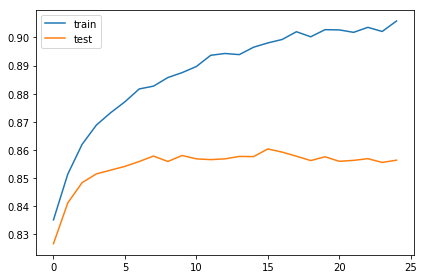

In [2]:
with h5py.File('data/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('data/train_label.h5','r') as H:
    label = np.copy(H['label'])
    
mlp = MLP([128,32,10],activation=[None, 'logistic', 'softmax'])

losses, accuracies_train, accuracies_test = mlp.optimize(data, label, learning_rate=0.01,epochs=25)

plt.plot(accuracies_train, label='train')
plt.plot(accuracies_test, label='test')
plt.tight_layout()
plt.legend()
#plt.savefig('accuracy.png')